<a id='top'></a>

# Méthodes de Monte-Carlo en Finance

# Projet 2 : Option barrière et diffusion tuée

Pierre ARTIGALA - Omar MANSOUR

## Consignes

Ce projet a pour but d'étudier le calcul du prix de certaines options barrières par méthode de Monte Carlo. Il se fonde sur l'article "Weak approximation of killed diffusion using Euler schemes" qui étudie deux méthodes de simulations. Votre rapport comportera au minimum :
- Une présentation du prix des options barrières dans le modèle de Black-Scholes pour obtenir des formules fermées.
- Une présentation des deux méthodes de l'article en commentant les démarches de preuves.
- Des simulatons testant ces méthodes (contre le formules fermées).

# Table of contents

## [Imports](#imports)
## [1. Prix des options barrières dans le modèle de Black-Scholes - Formules fermées](#part1)
## [2. Méthodes de Monte Carlo (article)](#part2)
## [3. Comparaison des différentes méthodes](#part3)

<a id='imports'></a>

# Imports [[^]](#top)

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from barrier_options import plot_price_vs_volatility, plot_price_surface, mc_pricer_discrete, mc_pricer_continuous, compare_prices, convergence, convergence_price

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

<a id='part1'></a>

# 1. Prix des options barrières dans le modèle de Black-Scholes - Formules fermées [[^]](#top)

## Knock-Out Barrier

Formules basées sur : https://personal.ntu.edu.sg/nprivault/MA5182/barrier-options.pdf

ÉCRIRE LES PRIX ET DÉCIDER DE SI ON DOIT INCLURE LA DÉMONSTRATION POUR AU MOINS UN PRIX.

## Knock-In Barrier

Formules basées sur https://www.asc.tuwien.ac.at/~juengel/simulations/fincalculator/doc/Barrier.pdf

Je suis un peu étonné parce que les formules comme c_ui = c - c_uo sont valables pour tout K, B (X, H dans le document) mais il garde la disjonction de cas H < B vs H >= B au lieu de simplifier...

# Plots

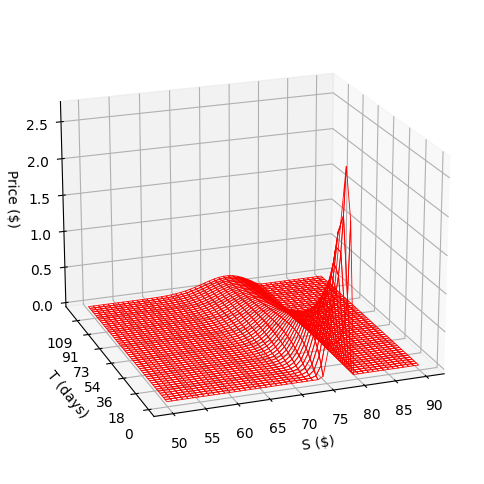

In [2]:
K = 75
B = 79
r = 0.03
sigma = 0.12
type_option = "call"
type_barrier = "up_out"
elev = 20
azim = 250

price = plot_price_surface(
    K=K,
    B=B,
    r=r,
    sigma=sigma,
    type_option=type_option,
    type_barrier=type_barrier,
    elev=elev,
    azim=azim)

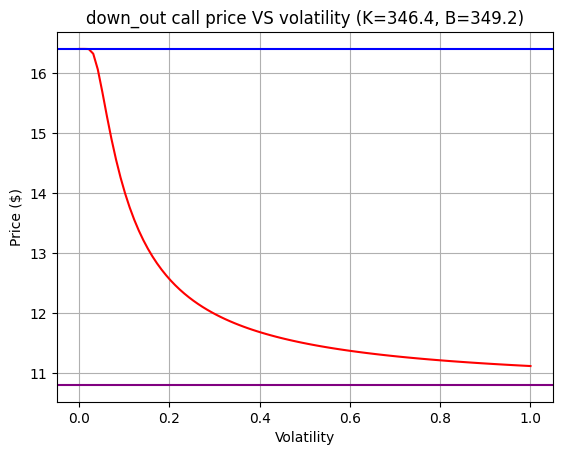

In [3]:
S = 360
K = 346.4
B = 349.2
r = 0.03
T = 99/365
type_option = "call"
type_barrier = "down_out"

plot_price_vs_volatility(S=S, K=K, B=B, r=r, T=T, type_option=type_option, type_barrier=type_barrier)

<a id='part2'></a>

# 2. Méthodes de Monte Carlo (article) [[^]](#top)

## Discrete Euler Scheme

In [4]:
# Starting point
x = 100
# Strike
K = 110
# Domain
B = 90
# Time
T = 1
# Number of time steps
N = 1000
# Number of simulations
M = 10000
# Risk-free interest rate
r = 0.05
# Volatility
sigma = 0.2
direction = "down"
knock = "in"
type_option = "put"


price = mc_pricer_discrete(
    x=x,
    K=K,
    B=B,
    T=T,
    N=N,
    M=M,
    r=r,
    sigma=sigma,
    type_option=type_option,
    direction=direction,
    knock=knock,
    )
price

(9.598292538397795, 12.525012352287554)

## Continuous Euler Scheme

In [5]:
# Starting point
x = 100
# Strike
K = 110
# Domain
B = 95
# Time
T = 1
# Number of time steps
N = 1000
# Number of simulations
M = 10000
# Risk-free interest rate
r = 0.05
# Volatility
sigma = 0.2
direction = "down"
knock = "in"
type_option = "put"


price = mc_pricer_continuous(
    x=x,
    K=K,
    B=B,
    T=T,
    N=N,
    M=M,
    r=r,
    sigma=sigma,
    type_option=type_option,
    direction=direction,
    knock=knock,
    )
price

(10.22684110443186, 12.010213825398067)

<a id='part3'></a>

# 3. Comparaison des différentes méthodes [[^]](#top)

In [6]:
# Starting point
S = 100
# Strike
K = 110
# Time
T = 1
# Number of time steps
N = 1000
# Number of simulations
M = 50000
# Risk-free interest rate
r = 0.05
# Volatility
sigma = 0.2
B = 120
direction = "down"
knock = "in"
type_option = "put"


price_closed, price_mc_discrete, price_mc_continuous = compare_prices(
    S=S,
    K=K,
    T=T,
    N=N,
    M=M,
    r=r,
    sigma=sigma,
    B=B,
    type_option=type_option,
    direction=direction,
    knock=knock,
)["price"]

print("Compare prices for " + direction + "_" + knock + " " + type_option)
print("Closed:", price_closed)
print("MC discrete:", price_mc_discrete)
print("MC continuous:", price_mc_continuous)

Compare prices for down_in put
Closed: 10.675324824802793
MC discrete: 10.69591525758951
MC continuous: 10.617199051233932


## Convergence des schémas d'Euler

[9.38874300e-04 5.63369812e-04 1.69370569e-04 2.49373230e-05
 2.92971619e-04]


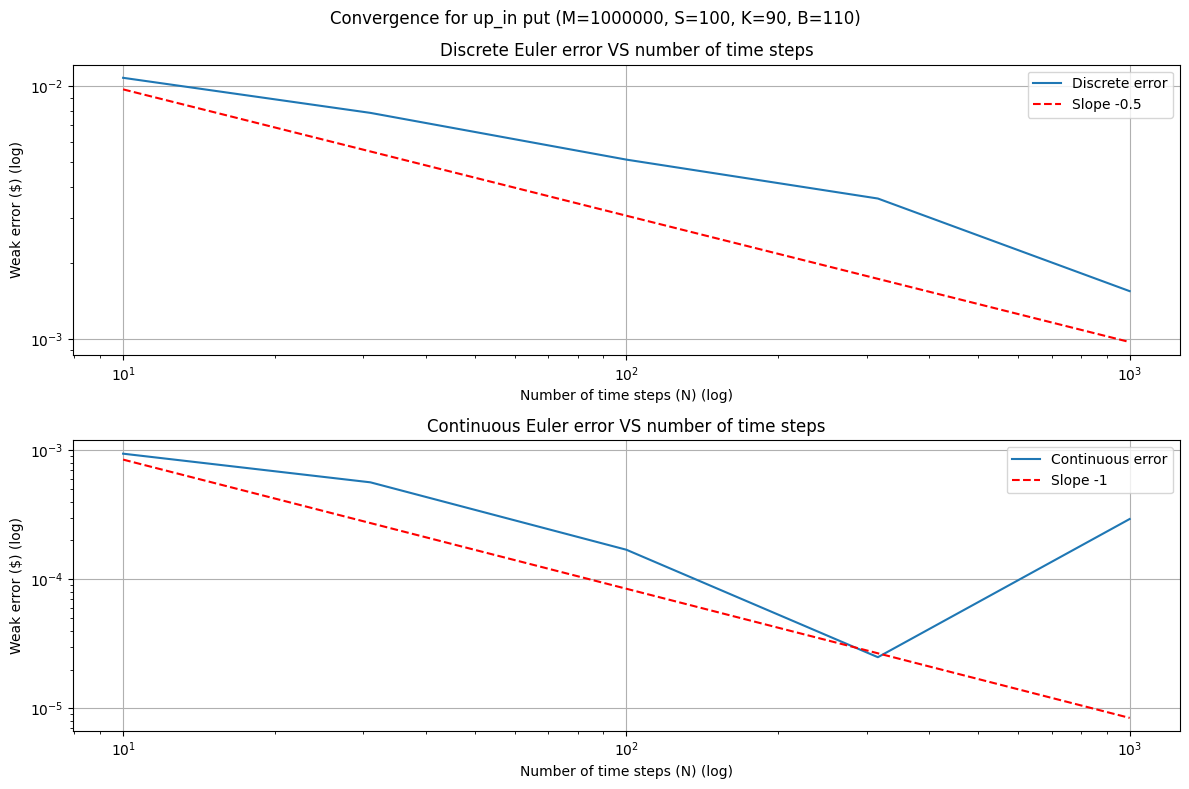

In [16]:
# Starting point
S = 100
# Strike
K = 90
# Time
T = 1
# Number of simulations
M = 10**6
# Risk-free interest rate
r = 0.03
# Volatility
sigma = 0.12
B = 110
direction = "up"
knock = "in"
type_option = "put"
nb_points = 5

convergence(
    S=S,
    K=K,
    T=T,
    M=M,
    r=r,
    sigma=sigma,
    B=B,
    type_option=type_option,
    direction=direction,
    knock=knock,
    nb_points=nb_points
)

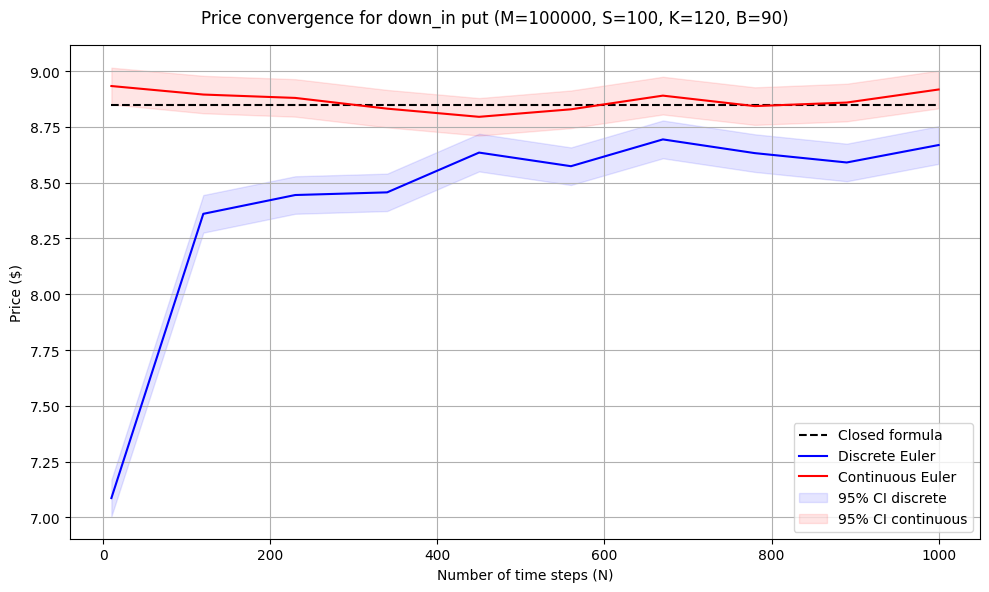

In [24]:
# Starting point
S = 100
# Strike
K = 120
# Time
T = 1
# Number of simulations
M = 100000
# Risk-free interest rate
r = 0.03
# Volatility
sigma = 0.12
B = 90
direction = "down"
knock = "in"
type_option = "put"
nb_points = 10
alpha=0.05

convergence_price(
    S=S,
    K=K,
    T=T,
    M=M,
    r=r,
    sigma=sigma,
    B=B,
    type_option=type_option,
    direction=direction,
    knock=knock,
    nb_points=nb_points,
    alpha=alpha
)

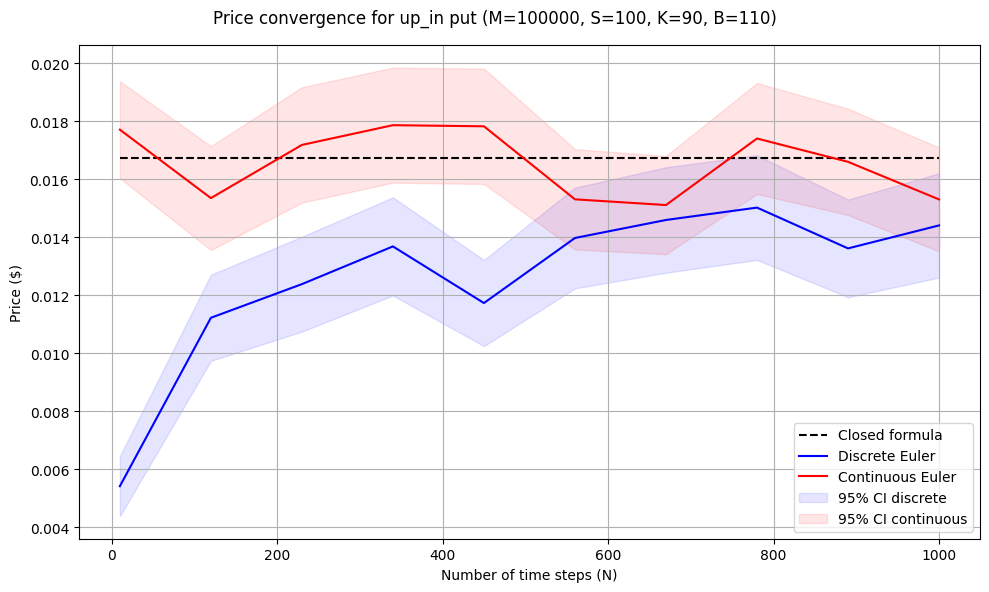

In [26]:
# Starting point
S = 100
# Strike
K = 90
# Time
T = 1
# Number of simulations
M = 100000
# Risk-free interest rate
r = 0.03
# Volatility
sigma = 0.12
B = 110
direction = "up"
knock = "in"
type_option = "put"
nb_points = 10
alpha=0.05

convergence_price(
    S=S,
    K=K,
    T=T,
    M=M,
    r=r,
    sigma=sigma,
    B=B,
    type_option=type_option,
    direction=direction,
    knock=knock,
    nb_points=nb_points,
    alpha=alpha
)

# Draft